# Load modules

In [1]:
%cd ~/Workspace/kaggle-2019Q3-cellular/

/home/chengjiun/Workspace/kaggle-2019Q3-cellular


In [2]:
import os
import numpy as np
import pandas as pd

from fastai.vision import *
BASE_DIR = '../DATA/kaggle-2019Q3-cellular/'


def open_rcic_image(fn):
    images = []
    for i in range(6):
        file_name = fn+str(i+1)+'.png'
        im = cv2.imread(file_name)
        if im is None: 
            print(f'file reading failed {file_name}')
        
        im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
        images.append(im)
    image = np.dstack(images)
    #print(pil2tensor(image, np.float32).shape)#.div_(255).shape)
    return Image(pil2tensor(image, np.float32).div_(255))
  
class MultiChannelImageList(ImageList):
    def open(self, fn):
        return open_rcic_image(fn)
    
def image2np(image:Tensor)->np.ndarray:
    "Convert from torch style `image` to numpy/matplotlib style."
    res = image.cpu().permute(1,2,0).numpy()
    if res.shape[2]==1:
        return res[...,0]  
    elif res.shape[2]>3:
        #print(res.shape)
        #print(res[...,:3].shape)
        return res[...,:3]
    else:
        return res

vision.image.image2np = image2np

## efficientnet

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline  
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
import cv2
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision import models as md
from torch import nn
from torch.nn import functional as F
import scipy as sp
import re
import math
import collections
from functools import partial
from torch.utils import model_zoo
from sklearn import metrics
from collections import Counter
import json

In [4]:
#original code below is from: https://github.com/lukemelas/EfficientNet-PyTorch


"""
This file contains helper functions for building the model and for loading model parameters.
These helper functions are built to mirror those in the official TensorFlow implementation.
"""


# Parameters for the entire model (stem, all blocks, and head)
GlobalParams = collections.namedtuple('GlobalParams', [
    'batch_norm_momentum', 'batch_norm_epsilon', 'dropout_rate',
    'num_classes', 'width_coefficient', 'depth_coefficient',
    'depth_divisor', 'min_depth', 'drop_connect_rate', 'image_size'])


# Parameters for an individual model block
BlockArgs = collections.namedtuple('BlockArgs', [
    'kernel_size', 'num_repeat', 'input_filters', 'output_filters',
    'expand_ratio', 'id_skip', 'stride', 'se_ratio'])


# Change namedtuple defaults
GlobalParams.__new__.__defaults__ = (None,) * len(GlobalParams._fields)
BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)


def relu_fn(x):
    """ Swish activation function """
    return x * torch.sigmoid(x)


def round_filters(filters, global_params):
    """ Calculate and round number of filters based on depth multiplier. """
    multiplier = global_params.width_coefficient
    if not multiplier:
        return filters
    divisor = global_params.depth_divisor
    min_depth = global_params.min_depth
    filters *= multiplier
    min_depth = min_depth or divisor
    new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
    if new_filters < 0.9 * filters:  # prevent rounding by more than 10%
        new_filters += divisor
    return int(new_filters)


def round_repeats(repeats, global_params):
    """ Round number of filters based on depth multiplier. """
    multiplier = global_params.depth_coefficient
    if not multiplier:
        return repeats
    return int(math.ceil(multiplier * repeats))


def drop_connect(inputs, p, training):
    """ Drop connect. """
    if not training: return inputs
    batch_size = inputs.shape[0]
    keep_prob = 1 - p
    random_tensor = keep_prob
    random_tensor += torch.rand([batch_size, 1, 1, 1], dtype=inputs.dtype, device=inputs.device)
    binary_tensor = torch.floor(random_tensor)
    output = inputs / keep_prob * binary_tensor
    return output


def get_same_padding_conv2d(image_size=None):
    """ Chooses static padding if you have specified an image size, and dynamic padding otherwise.
        Static padding is necessary for ONNX exporting of models. """
    if image_size is None:
        return Conv2dDynamicSamePadding
    else:
        return partial(Conv2dStaticSamePadding, image_size=image_size)

class Conv2dDynamicSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow, for a dynamic image size """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, 0, dilation, groups, bias)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]]*2

    def forward(self, x):
        ih, iw = x.size()[-2:]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, [pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2])
        return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


class Conv2dStaticSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow, for a fixed image size"""
    def __init__(self, in_channels, out_channels, kernel_size, image_size=None, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

        # Calculate padding based on image size and save it
        assert image_size is not None
        ih, iw = image_size if type(image_size) == list else [image_size, image_size]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            self.static_padding = nn.ZeroPad2d((pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2))
        else:
            self.static_padding = Identity()

    def forward(self, x):
        x = self.static_padding(x)
        x = F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
        return x


class Identity(nn.Module):
    def __init__(self,):
        super(Identity, self).__init__()

    def forward(self, input):
        return input


########################################################################
############## HELPERS FUNCTIONS FOR LOADING MODEL PARAMS ##############
########################################################################


def efficientnet_params(model_name):
    """ Map EfficientNet model name to parameter coefficients. """
    params_dict = {
        # Coefficients:   width,depth,res,dropout
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5),
    }
    return params_dict[model_name]


class BlockDecoder(object):
    """ Block Decoder for readability, straight from the official TensorFlow repository """

    @staticmethod
    def _decode_block_string(block_string):
        """ Gets a block through a string notation of arguments. """
        assert isinstance(block_string, str)

        ops = block_string.split('_')
        options = {}
        for op in ops:
            splits = re.split(r'(\d.*)', op)
            if len(splits) >= 2:
                key, value = splits[:2]
                options[key] = value

        # Check stride
        assert (('s' in options and len(options['s']) == 1) or
                (len(options['s']) == 2 and options['s'][0] == options['s'][1]))

        return BlockArgs(
            kernel_size=int(options['k']),
            num_repeat=int(options['r']),
            input_filters=int(options['i']),
            output_filters=int(options['o']),
            expand_ratio=int(options['e']),
            id_skip=('noskip' not in block_string),
            se_ratio=float(options['se']) if 'se' in options else None,
            stride=[int(options['s'][0])])

    @staticmethod
    def _encode_block_string(block):
        """Encodes a block to a string."""
        args = [
            'r%d' % block.num_repeat,
            'k%d' % block.kernel_size,
            's%d%d' % (block.strides[0], block.strides[1]),
            'e%s' % block.expand_ratio,
            'i%d' % block.input_filters,
            'o%d' % block.output_filters
        ]
        if 0 < block.se_ratio <= 1:
            args.append('se%s' % block.se_ratio)
        if block.id_skip is False:
            args.append('noskip')
        return '_'.join(args)

    @staticmethod
    def decode(string_list):
        """
        Decodes a list of string notations to specify blocks inside the network.

        :param string_list: a list of strings, each string is a notation of block
        :return: a list of BlockArgs namedtuples of block args
        """
        assert isinstance(string_list, list)
        blocks_args = []
        for block_string in string_list:
            blocks_args.append(BlockDecoder._decode_block_string(block_string))
        return blocks_args

    @staticmethod
    def encode(blocks_args):
        """
        Encodes a list of BlockArgs to a list of strings.

        :param blocks_args: a list of BlockArgs namedtuples of block args
        :return: a list of strings, each string is a notation of block
        """
        block_strings = []
        for block in blocks_args:
            block_strings.append(BlockDecoder._encode_block_string(block))
        return block_strings


def efficientnet(width_coefficient=None, depth_coefficient=None, dropout_rate=0.2,
                 drop_connect_rate=0.2, image_size=None, num_classes=1000):
    """ Creates a efficientnet model. """

    blocks_args = [
        'r1_k3_s11_e1_i32_o16_se0.25', 'r2_k3_s22_e6_i16_o24_se0.25',
        'r2_k5_s22_e6_i24_o40_se0.25', 'r3_k3_s22_e6_i40_o80_se0.25',
        'r3_k5_s11_e6_i80_o112_se0.25', 'r4_k5_s22_e6_i112_o192_se0.25',
        'r1_k3_s11_e6_i192_o320_se0.25',
    ]
    blocks_args = BlockDecoder.decode(blocks_args)

    global_params = GlobalParams(
        batch_norm_momentum=0.99,
        batch_norm_epsilon=1e-3,
        dropout_rate=dropout_rate,
        drop_connect_rate=drop_connect_rate,
        # data_format='channels_last',  # removed, this is always true in PyTorch
        num_classes=num_classes,
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        depth_divisor=8,
        min_depth=None,
        image_size=image_size,
    )

    return blocks_args, global_params


def get_model_params(model_name, override_params):
    """ Get the block args and global params for a given model """
    if model_name.startswith('efficientnet'):
        w, d, s, p = efficientnet_params(model_name)
        # note: all models have drop connect rate = 0.2
        blocks_args, global_params = efficientnet(
            width_coefficient=w, depth_coefficient=d, dropout_rate=p, image_size=s)
    else:
        raise NotImplementedError('model name is not pre-defined: %s' % model_name)
    if override_params:
        # ValueError will be raised here if override_params has fields not included in global_params.
        global_params = global_params._replace(**override_params)
    return blocks_args, global_params


url_map = {
    'efficientnet-b0': 'http://storage.googleapis.com/public-models/efficientnet-b0-08094119.pth',
    'efficientnet-b1': 'http://storage.googleapis.com/public-models/efficientnet-b1-dbc7070a.pth',
    'efficientnet-b2': 'http://storage.googleapis.com/public-models/efficientnet-b2-27687264.pth',
    'efficientnet-b3': 'http://storage.googleapis.com/public-models/efficientnet-b3-c8376fa2.pth',
    'efficientnet-b4': 'http://storage.googleapis.com/public-models/efficientnet-b4-e116e8b3.pth',
    'efficientnet-b5': 'http://storage.googleapis.com/public-models/efficientnet-b5-586e6cc6.pth',
    'efficientnet-b6': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b6-c76e70fd.pth',
    'efficientnet-b7': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b7-dcc49843.pth',
}

def load_pretrained_weights(model, model_name, load_fc=True):
    """ Loads pretrained weights, and downloads if loading for the first time. """
    state_dict = model_zoo.load_url(url_map[model_name])
    if load_fc:
        model.load_state_dict(state_dict)
    else:
        state_dict.pop('_fc.weight')
        state_dict.pop('_fc.bias')
        res = model.load_state_dict(state_dict, strict=False)
        assert str(res.missing_keys) == str(['_fc.weight', '_fc.bias']), 'issue loading pretrained weights'
    print('Loaded pretrained weights for {}'.format(model_name))
    
    
class MBConvBlock(nn.Module):
    """
    Mobile Inverted Residual Bottleneck Block

    Args:
        block_args (namedtuple): BlockArgs, see above
        global_params (namedtuple): GlobalParam, see above

    Attributes:
        has_se (bool): Whether the block contains a Squeeze and Excitation layer.
    """

    def __init__(self, block_args, global_params):
        super().__init__()
        self._block_args = block_args
        self._bn_mom = 1 - global_params.batch_norm_momentum
        self._bn_eps = global_params.batch_norm_epsilon
        self.has_se = (self._block_args.se_ratio is not None) and (0 < self._block_args.se_ratio <= 1)
        self.id_skip = block_args.id_skip  # skip connection and drop connect

        # Get static or dynamic convolution depending on image size
        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)

        # Expansion phase
        inp = self._block_args.input_filters  # number of input channels
        oup = self._block_args.input_filters * self._block_args.expand_ratio  # number of output channels
        if self._block_args.expand_ratio != 1:
            self._expand_conv = Conv2d(in_channels=inp, out_channels=oup, kernel_size=1, bias=False)
            self._bn0 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        # Depthwise convolution phase
        k = self._block_args.kernel_size
        s = self._block_args.stride
        self._depthwise_conv = Conv2d(
            in_channels=oup, out_channels=oup, groups=oup,  # groups makes it depthwise
            kernel_size=k, stride=s, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        # Squeeze and Excitation layer, if desired
        if self.has_se:
            num_squeezed_channels = max(1, int(self._block_args.input_filters * self._block_args.se_ratio))
            self._se_reduce = Conv2d(in_channels=oup, out_channels=num_squeezed_channels, kernel_size=1)
            self._se_expand = Conv2d(in_channels=num_squeezed_channels, out_channels=oup, kernel_size=1)

        # Output phase
        final_oup = self._block_args.output_filters
        self._project_conv = Conv2d(in_channels=oup, out_channels=final_oup, kernel_size=1, bias=False)
        self._bn2 = nn.BatchNorm2d(num_features=final_oup, momentum=self._bn_mom, eps=self._bn_eps)

    def forward(self, inputs, drop_connect_rate=None):
        """
        :param inputs: input tensor
        :param drop_connect_rate: drop connect rate (float, between 0 and 1)
        :return: output of block
        """

        # Expansion and Depthwise Convolution
        x = inputs
        if self._block_args.expand_ratio != 1:
            x = relu_fn(self._bn0(self._expand_conv(inputs)))
        x = relu_fn(self._bn1(self._depthwise_conv(x)))

        # Squeeze and Excitation
        if self.has_se:
            x_squeezed = F.adaptive_avg_pool2d(x, 1)
            x_squeezed = self._se_expand(relu_fn(self._se_reduce(x_squeezed)))
            x = torch.sigmoid(x_squeezed) * x

        x = self._bn2(self._project_conv(x))

        # Skip connection and drop connect
        input_filters, output_filters = self._block_args.input_filters, self._block_args.output_filters
        if self.id_skip and self._block_args.stride == 1 and input_filters == output_filters:
            if drop_connect_rate:
                x = drop_connect(x, p=drop_connect_rate, training=self.training)
            x = x + inputs  # skip connection
        return x


class EfficientNet(nn.Module):
    """
    An EfficientNet model. Most easily loaded with the .from_name or .from_pretrained methods

    Args:
        blocks_args (list): A list of BlockArgs to construct blocks
        global_params (namedtuple): A set of GlobalParams shared between blocks

    Example:
        model = EfficientNet.from_pretrained('efficientnet-b0')

    """

    def __init__(self, blocks_args=None, global_params=None):
        super().__init__()
        assert isinstance(blocks_args, list), 'blocks_args should be a list'
        assert len(blocks_args) > 0, 'block args must be greater than 0'
        self._global_params = global_params
        self._blocks_args = blocks_args

        # Get static or dynamic convolution depending on image size
        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)

        # Batch norm parameters
        bn_mom = 1 - self._global_params.batch_norm_momentum
        bn_eps = self._global_params.batch_norm_epsilon

        # Stem
        in_channels = 3  # rgb
        out_channels = round_filters(32, self._global_params)  # number of output channels
        self._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        self._bn0 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Build blocks
        self._blocks = nn.ModuleList([])
        for block_args in self._blocks_args:

            # Update block input and output filters based on depth multiplier.
            block_args = block_args._replace(
                input_filters=round_filters(block_args.input_filters, self._global_params),
                output_filters=round_filters(block_args.output_filters, self._global_params),
                num_repeat=round_repeats(block_args.num_repeat, self._global_params)
            )

            # The first block needs to take care of stride and filter size increase.
            self._blocks.append(MBConvBlock(block_args, self._global_params))
            if block_args.num_repeat > 1:
                block_args = block_args._replace(input_filters=block_args.output_filters, stride=1)
            for _ in range(block_args.num_repeat - 1):
                self._blocks.append(MBConvBlock(block_args, self._global_params))

        # Head
        in_channels = block_args.output_filters  # output of final block
        out_channels = round_filters(1280, self._global_params)
        self._conv_head = Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Final linear layer
        self._dropout = self._global_params.dropout_rate
        self._fc = nn.Linear(out_channels, self._global_params.num_classes)

    def extract_features(self, inputs):
        """ Returns output of the final convolution layer """

        # Stem
        x = relu_fn(self._bn0(self._conv_stem(inputs)))

        # Blocks
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)
            x = block(x, drop_connect_rate=drop_connect_rate)

        # Head
        x = relu_fn(self._bn1(self._conv_head(x)))

        return x

    def forward(self, inputs):
        """ Calls extract_features to extract features, applies final linear layer, and returns logits. """

        # Convolution layers
        x = self.extract_features(inputs)

        # Pooling and final linear layer
        x = F.adaptive_avg_pool2d(x, 1).squeeze(-1).squeeze(-1)
        if self._dropout:
            x = F.dropout(x, p=self._dropout, training=self.training)
        x = self._fc(x)
        return x

    @classmethod
    def from_name(cls, model_name, override_params=None):
        cls._check_model_name_is_valid(model_name)
        blocks_args, global_params = get_model_params(model_name, override_params)
        return EfficientNet(blocks_args, global_params)

    @classmethod
    def from_pretrained(cls, model_name, num_classes=1000):
        model = EfficientNet.from_name(model_name, override_params={'num_classes': num_classes})
        return model

    @classmethod
    def get_image_size(cls, model_name):
        cls._check_model_name_is_valid(model_name)
        _, _, res, _ = efficientnet_params(model_name)
        return res

    @classmethod
    def _check_model_name_is_valid(cls, model_name, also_need_pretrained_weights=False):
        """ Validates model name. None that pretrained weights are only available for
        the first four models (efficientnet-b{i} for i in 0,1,2,3) at the moment. """
        num_models = 4 if also_need_pretrained_weights else 8
        valid_models = ['efficientnet_b'+str(i) for i in range(num_models)]
        if model_name.replace('-','_') not in valid_models:
            raise ValueError('model_name should be one of: ' + ', '.join(valid_models))
            

# Set seed fol all
def seed_everything(seed=1358):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
    


seed_everything()

## utils

In [5]:
#lazy calculation of stats
pixel_stats = pd.read_csv(f'{BASE_DIR}/pixel_stats.csv')
channel1_mean = pixel_stats.iloc[::6,:]['mean'].mean()
channel2_mean = pixel_stats.iloc[1::6,:]['mean'].mean()
channel3_mean = pixel_stats.iloc[2::6,:]['mean'].mean()
channel4_mean = pixel_stats.iloc[3::6,:]['mean'].mean()
channel5_mean = pixel_stats.iloc[4::6,:]['mean'].mean()
channel6_mean = pixel_stats.iloc[5::6,:]['mean'].mean()


channel1_std = pixel_stats.iloc[::6,:]['std'].mean()
channel2_std = pixel_stats.iloc[1::6,:]['std'].mean()
channel3_std = pixel_stats.iloc[2::6,:]['std'].mean()
channel4_std = pixel_stats.iloc[3::6,:]['std'].mean()
channel5_std = pixel_stats.iloc[4::6,:]['std'].mean()
channel6_std = pixel_stats.iloc[5::6,:]['std'].mean()
stats = (torch.Tensor([channel1_mean,channel2_mean,channel3_mean,channel4_mean,channel5_mean,channel6_mean])/255,torch.Tensor([channel1_std,channel2_std,channel3_std,channel4_std,channel5_std,channel6_std])/255)
print(stats)

(tensor([0.0229, 0.0611, 0.0396, 0.0391, 0.0219, 0.0356]), tensor([0.0271, 0.0492, 0.0219, 0.0292, 0.0183, 0.0193]))


## Loading and formatting data

Here I will load the csv into the DataFrame, and create a column in the DataFrame with the path to the corresponding image (`generate_df`)

In [6]:
train_df = pd.read_csv(f'{BASE_DIR}/train.csv')
train_df.head(10)

,id_code,experiment,plate,well,sirna
0,HEPG2-01_1_B03,HEPG2-01,1,B03,513
1,HEPG2-01_1_B04,HEPG2-01,1,B04,840
2,HEPG2-01_1_B05,HEPG2-01,1,B05,1020
3,HEPG2-01_1_B06,HEPG2-01,1,B06,254
4,HEPG2-01_1_B07,HEPG2-01,1,B07,144
5,HEPG2-01_1_B08,HEPG2-01,1,B08,503
6,HEPG2-01_1_B09,HEPG2-01,1,B09,188
7,HEPG2-01_1_B10,HEPG2-01,1,B10,700
8,HEPG2-01_1_B11,HEPG2-01,1,B11,1100
9,HEPG2-01_1_B12,HEPG2-01,1,B12,611


In [7]:
exp_list = ['HEPG2', 'HUVEC', 'RPE', 'U2OS']
def generate_df(train_df,sample_num=[1,2],exp=None):
    if exp is not None:
        train_df = train_df[train_df['exp'] == exp]
        print(f'extract experiment: {exp}, number of train data {len(train_df)}')
    temp_df = train_df.drop(columns=['id_code','experiment','plate','well'])
    res_df = pd.DataFrame()
    for s in sample_num:
        temp_df['path'] = (train_df['experiment'].str.cat(train_df['plate'].astype(str)
                                                .str.cat(train_df['well'],sep='/'),sep='/Plate') + '_s'+str(s) + '_w')
        
        temp_df = temp_df.reindex(columns=['path','sirna'])
        if len(res_df) ==0:
            res_df = temp_df.copy(deep=True)
        else:
            res_df = pd.concat([temp_df, res_df], axis=0, sort=False)
            
    return res_df

proc_train_all_df = generate_df(train_df, sample_num=[1,2])


In [8]:
proc_train_all_df.head(10)

,path,sirna
0,HEPG2-01/Plate1/B03_s2_w,513
1,HEPG2-01/Plate1/B04_s2_w,840
2,HEPG2-01/Plate1/B05_s2_w,1020
3,HEPG2-01/Plate1/B06_s2_w,254
4,HEPG2-01/Plate1/B07_s2_w,144
5,HEPG2-01/Plate1/B08_s2_w,503
6,HEPG2-01/Plate1/B09_s2_w,188
7,HEPG2-01/Plate1/B10_s2_w,700
8,HEPG2-01/Plate1/B11_s2_w,1100
9,HEPG2-01/Plate1/B12_s2_w,611


In [9]:
il = MultiChannelImageList.from_df(df=proc_train_all_df,path='../DATA/kaggle-2019Q3-cellular/train/')

## Creating and Training a Model

I will use a pretrained ResNet. I have to now adjust the CNN arch to take in 6 channels as opposed to the usual 3 channels:

In [10]:
"""Inspired by https://github.com/wdhorton/protein-atlas-fastai/blob/master/resnet.py"""

import torchvision
RESNET_MODELS = {
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
    '101x': torchvision.models.resnext101_32x8d,
}


def resnet_multichannel(depth=50,pretrained=True,num_classes=1108,num_channels=6):
    model = RESNET_MODELS[depth](pretrained=pretrained)
    w = model.conv1.weight
    model.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3,
                           bias=False)
    model.conv1.weight = nn.Parameter(torch.cat((w,torch.zeros(64,num_channels-3,7,7)),dim=1))
    return model

def efficientnetb4_multichannel(name='efficientnet-b4', pretrained=True, num_classes=1108, num_channels=6):
    model = EfficientNet.from_pretrained(name, num_classes)
    load_pretrained_weights(model,model_name=name, load_fc=False)
    w = model._conv_stem.weight
    model._conv_stem = Conv2dStaticSamePadding(num_channels, 48, kernel_size=3, 
                                               image_size=image_size, stride=2, padding=3)
    model._conv_stem.weight = nn.Parameter(torch.cat((w,torch.zeros(48,num_channels-3,3,3)),dim=1))
    return model

def efficientnetb6_multichannel(name='efficientnet-b6', pretrained=True, num_classes=1108, num_channels=6):
    model = EfficientNet.from_pretrained(name, num_classes)
    load_pretrained_weights(model,model_name=name, load_fc=False)
    w = model._conv_stem.weight
    model._conv_stem = Conv2dStaticSamePadding(num_channels, 56, kernel_size=3, 
                                               image_size=image_size, stride=2, padding=3)
    model._conv_stem.weight = nn.Parameter(torch.cat((w,torch.zeros(56,num_channels-3,3,3)),dim=1))
    return model

In [13]:
model = EfficientNet.from_pretrained('efficientnet-b6', 1108)

In [17]:
image_size=384
def resnet34(pretrained,num_channels=6):
    return resnet_multichannel(depth=50,pretrained=pretrained,num_channels=num_channels)

def resnet50(pretrained,num_channels=6):
    return resnet_multichannel(depth=50,pretrained=pretrained,num_channels=num_channels)

def resnext101(pretrained,num_channels=6):
    return resnet_multichannel(depth='101x',pretrained=pretrained,num_channels=num_channels)

effnetb4 = efficientnetb4_multichannel('efficientnet-b4', pretrained=True,num_channels=6)

effnetb6 = efficientnetb6_multichannel('efficientnet-b6', pretrained=True,num_channels=6)

def _resnet_split(m): return (m[0][6],m[1])

Loaded pretrained weights for efficientnet-b4
Loaded pretrained weights for efficientnet-b6


In [12]:
"""From https://www.kaggle.com/leighplt/densenet121-pytorch"""
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return torch.Tensor(np.array(res))

Let's create our Learner:

In [39]:
del learn
del data
torch.cuda.empty_cache()


NameError: name 'learn' is not defined

In [13]:
from optim.ranger import Ranger
optar = partial(Ranger)

In [14]:
# 1080Ti 9G: img size=384, efficientnet-b4, bs=16
# 4Ti
image_size=384
tfms = get_transforms(do_flip=True, flip_vert=True,
                      max_lighting=0.2, p_lighting=0.5, 
                      max_warp=0., max_rotate=20., max_zoom=1.0)

data = (MultiChannelImageList.from_df(df=proc_train_all_df,path='../DATA/kaggle-2019Q3-cellular/train/')
        .split_by_rand_pct(0.1)
        .label_from_df()
        .transform(tfms,size=image_size)
        .databunch(bs=16,num_workers=16)
        .normalize(stats)
       )

In [20]:
learn = Learner(data, 
                effnetb4,
                metrics = [accuracy], 
                model_dir='./fastaimodels').to_fp16()
learn.model = torch.nn.DataParallel(learn.model)
learn.path = Path('./effb6-gce')


We can now find the appropriate learning rate and train the head of the model:

In [21]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: Caught RuntimeError in replica 1 on device 1.
Original Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/nn/parallel/parallel_apply.py", line 60, in _worker
    output = module(*input, **kwargs)
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/module.py", line 547, in __call__
    result = self.forward(*input, **kwargs)
  File "<ipython-input-4-b87b5eb25daa>", line 453, in forward
    x = self.extract_features(inputs)
  File "<ipython-input-4-b87b5eb25daa>", line 442, in extract_features
    x = block(x, drop_connect_rate=drop_connect_rate)
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/module.py", line 547, in __call__
    result = self.forward(*input, **kwargs)
  File "<ipython-input-4-b87b5eb25daa>", line 359, in forward
    x = self._bn2(self._project_conv(x))
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/module.py", line 547, in __call__
    result = self.forward(*input, **kwargs)
  File "<ipython-input-4-b87b5eb25daa>", line 115, in forward
    x = F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
RuntimeError: cuDNN error: CUDNN_STATUS_BAD_PARAM


In [26]:
learn.fit_one_cycle(5,1e-3, callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,6.589913,6.542411,1.122980,53:51
1,5.664667,5.661297,6.053136,49:35
2,4.721763,4.538495,15.420433,44:59
3,3.824983,3.779518,26.951521,42:17
4,3.323200,3.587581,29.389208,39:33


In [27]:
learn.save('effnetb4-stage-1')
learn.export()

/home/chengjiun/Softwares/anaconda3/envs/tensorflow/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type EfficientNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/chengjiun/Softwares/anaconda3/envs/tensorflow/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Conv2dStaticSamePadding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/chengjiun/Softwares/anaconda3/envs/tensorflow/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type MBConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/chengjiun/Softwares/anaconda3/envs/tensorflow/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Co

We will now unfreeze and train the entire model.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.10E-03


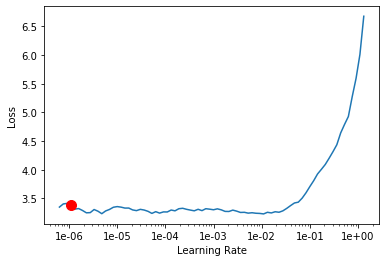

In [28]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [29]:
learn.fit_one_cycle(6,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.498375,3.784810,26.211996,41:19
1,3.812469,4.301818,20.734045,39:03
2,3.391553,3.853686,27.992331,38:15
3,2.596812,3.098163,38.537388,42:31
4,1.941670,2.755544,43.138866,41:47
5,1.650837,2.682113,44.754860,42:29


In [30]:
learn.save('effnetb4-stage-2')
learn.export()

In [33]:
learn.fit_one_cycle(5,1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.540594,2.709393,44.480965,47:49
1,1.530679,2.659583,45.768284,49:13
2,1.421624,2.683297,45.412216,50:37
3,1.289474,2.647002,46.316078,51:00
4,1.262001,2.684255,45.877842,51:34


In [38]:
learn.save('effnetb4-stage-2')
learn.export()

In [37]:
learn.fit_one_cycle(5,1e-6)

epoch,train_loss,valid_loss,accuracy,time
0,1.169876,2.618689,47.137772,52:11
1,1.172119,2.661130,46.206520,50:49
2,1.243145,2.644564,46.726925,53:35
3,1.235656,2.649640,46.562584,54:27
4,1.185921,2.644634,46.617367,53:57


## Inference and Submission Generation

In [39]:
test_df = pd.read_csv(f'{BASE_DIR}/test.csv')
proc_test_df = generate_df(test_df.copy(), sample_num=1)
data_test = MultiChannelImageList.from_df(df=proc_test_df,path=f'{BASE_DIR}/test/')
learn.data.add_test(data_test)

In [40]:
preds, _ = learn.get_preds(DatasetType.Test)
preds_ = preds.argmax(dim=-1)

In [42]:
proc_test_df = generate_df(test_df.copy(), sample_num=2)
data_test = MultiChannelImageList.from_df(df=proc_test_df,path=f'{BASE_DIR}/test/')
learn.data.add_test(data_test)
preds2, _ = learn.get_preds(DatasetType.Test)
preds2_ = preds2.argmax(dim=-1)

In [43]:
preds_mean = (preds + preds2)/2.

Let's open the sample submission file and load it with our predictions to create a submission.

In [44]:
submission_df = pd.read_csv(f'{BASE_DIR}/sample_submission.csv')
submission_df.sirna = preds_.numpy().astype(int)
submission_df.head(10)

,id_code,sirna
0,HEPG2-08_1_B03,52
1,HEPG2-08_1_B04,7
2,HEPG2-08_1_B05,92
3,HEPG2-08_1_B06,312
4,HEPG2-08_1_B07,135
5,HEPG2-08_1_B08,981
6,HEPG2-08_1_B09,118
7,HEPG2-08_1_B10,0
8,HEPG2-08_1_B11,520
9,HEPG2-08_1_B12,1090


In [45]:
## local CV: 0.46 single site
submission_df.to_csv('submission-effB4-384-singlesite.csv',index=False)

In [46]:
preds_mean_ = preds_mean.argmax(dim=-1)
submission_df['sirna'] = preds_mean_.numpy().astype(int)
submission_df.head(10)

,id_code,sirna
0,HEPG2-08_1_B03,468
1,HEPG2-08_1_B04,7
2,HEPG2-08_1_B05,1091
3,HEPG2-08_1_B06,908
4,HEPG2-08_1_B07,135
5,HEPG2-08_1_B08,981
6,HEPG2-08_1_B09,118
7,HEPG2-08_1_B10,638
8,HEPG2-08_1_B11,807
9,HEPG2-08_1_B12,778


In [47]:
## local CV: 0.46
submission_df.to_csv('submission-effB4-384-doublesite.csv',index=False)

In [41]:
## self-boost

In [52]:
sub_df = submission_df.copy(deep=True)

In [58]:
plate_groups[:10,:]

array([[4, 2, 3, 1],
       [1, 3, 4, 2],
       [2, 4, 1, 3],
       [1, 3, 4, 2],
       [3, 1, 2, 4],
       [1, 3, 4, 2],
       [1, 3, 4, 2],
       [2, 4, 1, 3],
       [1, 3, 4, 2],
       [4, 2, 3, 1]])

In [53]:
plate_groups = np.zeros((1108,4), int)
for sirna in range(1108):
    grp = train_df.loc[train_df.sirna==sirna,:].plate.value_counts().index.values
    assert len(grp) == 3
    plate_groups[sirna,0:3] = grp
    plate_groups[sirna,3] = 10 - grp.sum()
    


all_test_exp = test_df.experiment.unique()
group_plate_probs = np.zeros((len(all_test_exp),4))
for idx in range(len(all_test_exp)):
    preds = sub_df.loc[test_df.experiment == all_test_exp[idx],'sirna'].values
    pp_mult = np.zeros((len(preds),1108))
    pp_mult[range(len(preds)),preds] = 1
    
    sub_test = test_df.loc[test_df.experiment == all_test_exp[idx],:]
    assert len(pp_mult) == len(sub_test)
    
    for j in range(4):
        mask = np.repeat(plate_groups[np.newaxis, :, j], len(pp_mult), axis=0) == \
               np.repeat(sub_test.plate.values[:, np.newaxis], 1108, axis=1)
        
        group_plate_probs[idx,j] = np.array(pp_mult)[mask].sum()/len(pp_mult)

exp_to_group = group_plate_probs.argmax(1)
print(exp_to_group)


def select_plate_group(pp_mult, idx, 
                       test_df=test_df, all_test_exp=all_test_exp, plate_groups=plate_groups,
                       exp_to_group=exp_to_group):
    sub_test = test_df.loc[test_df.experiment == all_test_exp[idx],:]
    assert len(pp_mult) == len(sub_test)
    mask = np.repeat(plate_groups[np.newaxis, :, exp_to_group[idx]], len(pp_mult), axis=0) != \
           np.repeat(sub_test.plate.values[:, np.newaxis], 1108, axis=1)
    pp_mult[mask] = 0
    return pp_mult

[3 1 0 0 0 0 2 2 3 0 0 3 1 0 0 0 2 3]


In [54]:
for idx in range(len(all_test_exp)):
    #print('Experiment', idx)
    indices = (test_df.experiment == all_test_exp[idx])
    
    preds_slice = preds_mean.numpy()[indices,:].copy()
    
    preds_slice = select_plate_group(preds_slice, idx, 
                                     test_df=test_df, all_test_exp=all_test_exp, plate_groups=plate_groups,
                                     exp_to_group=exp_to_group)
    sub_df.loc[indices,'sirna'] = preds_slice.argmax(1)

In [55]:
submission_df['sirna2'] = sub_df['sirna']
(submission_df['sirna2'] != submission_df['sirna']).mean()

0.0

In [ ]:
sub_df.to_csv('submission-resnet101-doublesite-boost.csv',index=False)
sub_df.head()